# Navier-Stokes Spectral Method Fluid Simulation

#### Assumption Taken

Navier-Stokes equations `(incompressible viscous fluid)`
with a Spectral method

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def diffusion_solve( v, dt, nu, kSq ):
	v_hat = (np.fft.fftn( v )) / (1.0+dt*nu*kSq)
	v = np.real(np.fft.ifftn(v_hat))
	return v

In [4]:
def grad(v, kx, ky):
	v_hat = np.fft.fftn(v)
	dvx = np.real(np.fft.ifftn( 1j*kx * v_hat))
	dvy = np.real(np.fft.ifftn( 1j*ky * v_hat))
	return dvx, dvy

In [5]:
def div(vx, vy, kx, ky):
	dvx_x = np.real(np.fft.ifftn( 1j*kx * np.fft.fftn(vx)))
	dvy_y = np.real(np.fft.ifftn( 1j*ky * np.fft.fftn(vy)))
	return dvx_x + dvy_y

In [6]:
def curl(vx, vy, kx, ky):
	dvx_y = np.real(np.fft.ifftn( 1j*ky * np.fft.fftn(vx)))
	dvy_x = np.real(np.fft.ifftn( 1j*kx * np.fft.fftn(vy)))
	return dvy_x - dvx_y

In [7]:
def apply_dealias(f, dealias):
	f_hat = dealias * np.fft.fftn(f)
	return np.real(np.fft.ifftn( f_hat ))

In [14]:
def main():
	""" Navier-Stokes Simulation """

	# Simulation parameters
	N         = 400
	t         = 0
	tEnd      = 1
	dt        = 0.001
	tOut      = 0.01
	nu        = 0.001
	plotRealTime = True

	# Domain [0,1] x [0,1]
	L = 1
	xlin = np.linspace(0,L, num=N+1)  # Note: x=0 & x=1 are the same point!
	xlin = xlin[0:N]                  # chop off periodic point
	xx, yy = np.meshgrid(xlin, xlin)

	vx = -np.sin(2*np.pi*yy)
	vy =  np.sin(2*np.pi*xx*2)

	klin = 2.0 * np.pi / L * np.arange(-N/2, N/2)
	kmax = np.max(klin)
	kx, ky = np.meshgrid(klin, klin)
	kx = np.fft.ifftshift(kx)
	ky = np.fft.ifftshift(ky)
	kSq = kx**2 + ky**2
	kSq_inv = 1.0 / kSq
	kSq_inv[kSq==0] = 1

	dealias = (np.abs(kx) < (2./3.)*kmax) & (np.abs(ky) < (2./3.)*kmax)

	Nt = int(np.ceil(tEnd/dt))

	fig = plt.figure(figsize=(4,4), dpi=80)
	outputCount = 1

	for i in range(Nt):

		dvx_x, dvx_y = grad(vx, kx, ky)
		dvy_x, dvy_y = grad(vy, kx, ky)

		rhs_x = -(vx * dvx_x + vy * dvx_y)
		rhs_y = -(vx * dvy_x + vy * dvy_y)

		rhs_x = apply_dealias(rhs_x, dealias)
		rhs_y = apply_dealias(rhs_y, dealias)

		vx += dt * rhs_x
		vy += dt * rhs_y

		div_rhs = div(rhs_x, rhs_y, kx, ky)
		P = poisson_solve( div_rhs, kSq_inv )
		dPx, dPy = grad(P, kx, ky)

		vx += - dt * dPx
		vy += - dt * dPy

		vx = diffusion_solve( vx, dt, nu, kSq )
		vy = diffusion_solve( vy, dt, nu, kSq )

		wz = curl(vx, vy, kx, ky)

		t += dt

		plotThisTurn = False
		if t + dt > outputCount*tOut:
			plotThisTurn = True

		if (plotRealTime and plotThisTurn) or (i == Nt-1):

			plt.cla()
			plt.imshow(wz, cmap = 'RdBu')
			plt.clim(-20,20)
			ax = plt.gca()
			ax.invert_yaxis()
			ax.get_xaxis().set_visible(False)
			ax.get_yaxis().set_visible(False)
			ax.set_aspect('equal')
			plt.pause(0.001)
			outputCount += 1

	plt.savefig(f"navier-stokes-spectral-at-time-{t:.2f}.png",dpi=240)
	plt.show()

	return 0

<ipython-input-14-512679fad776>:28: RuntimeWarning: divide by zero encountered in divide
  kSq_inv = 1.0 / kSq


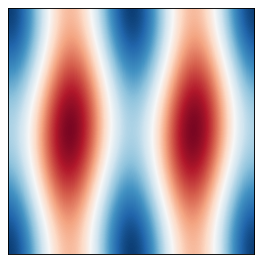

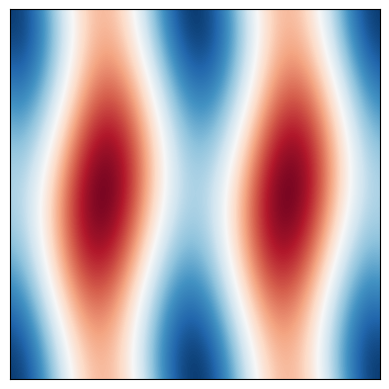

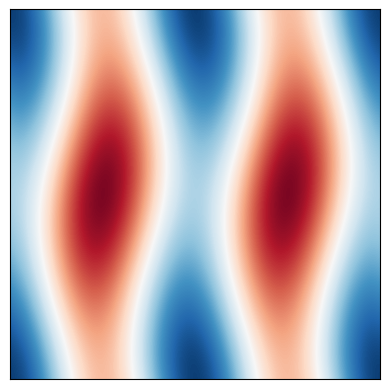

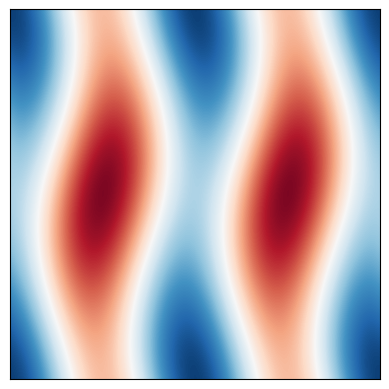

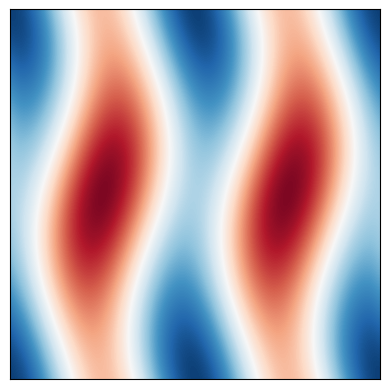

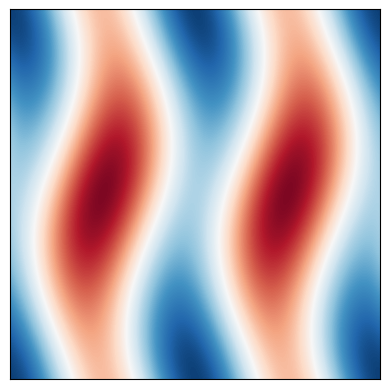

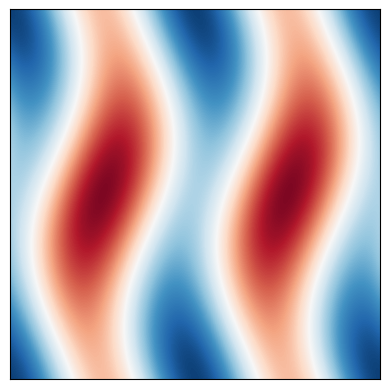

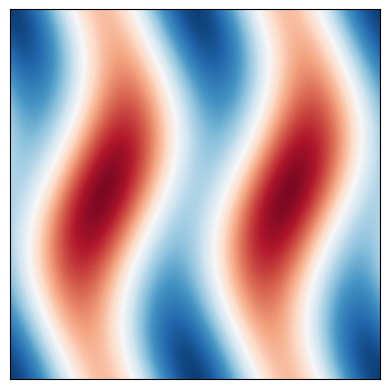

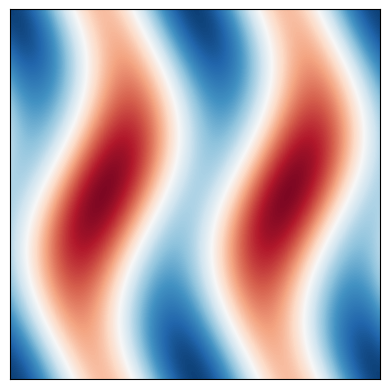

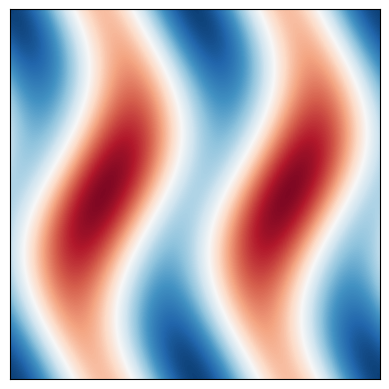

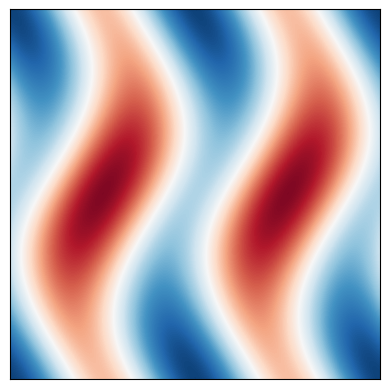

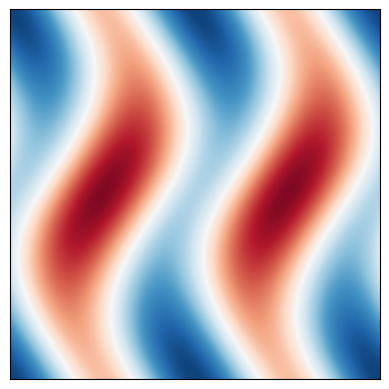

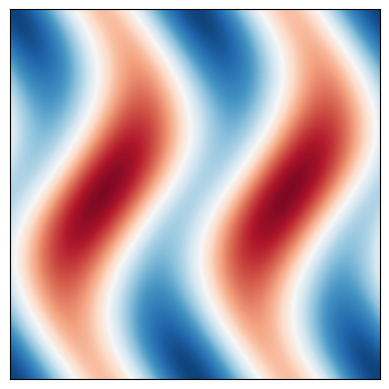

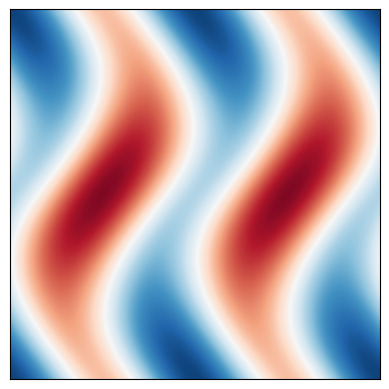

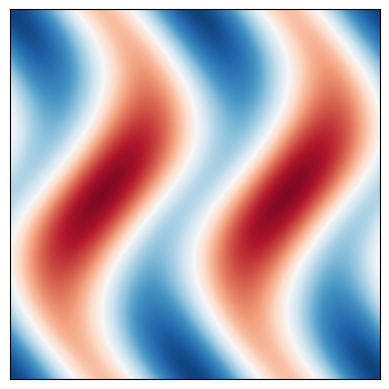

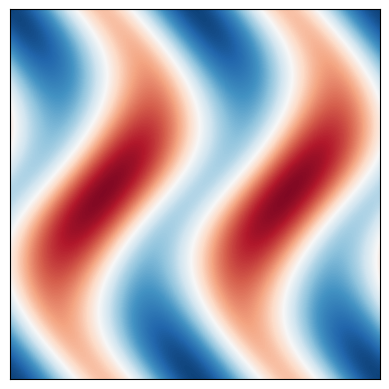

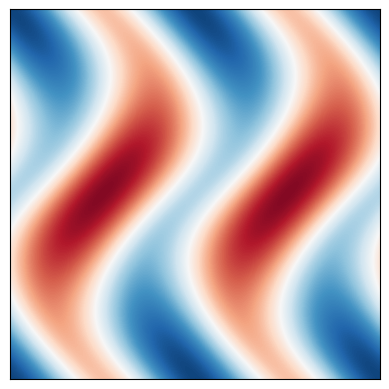

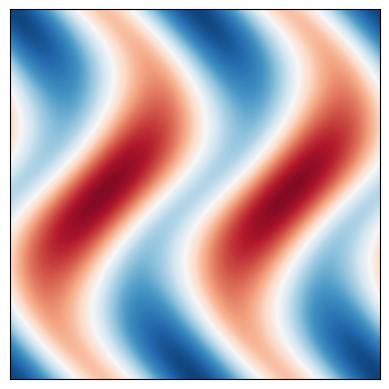

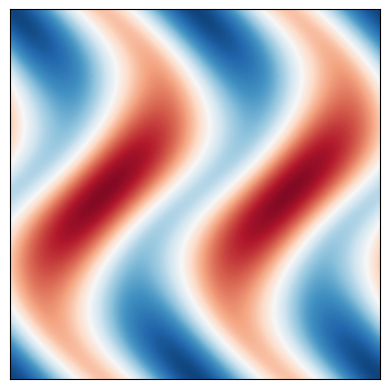

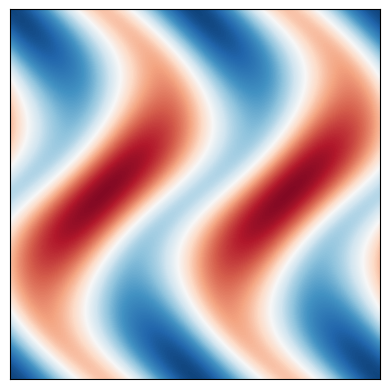

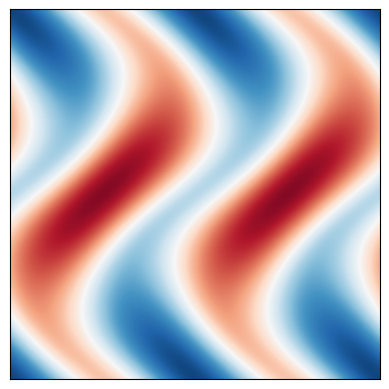

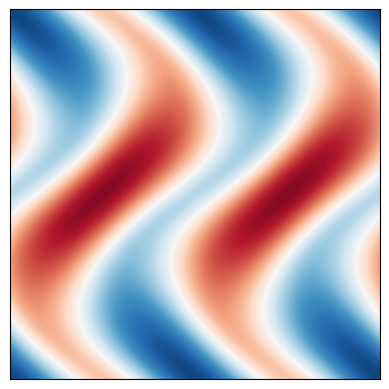

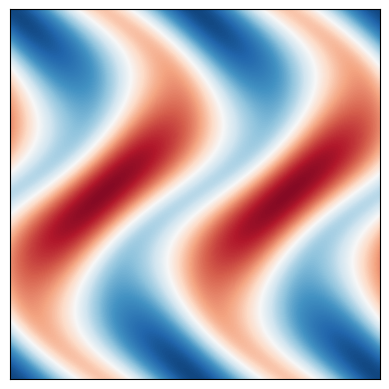

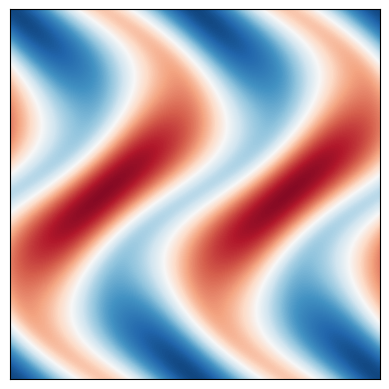

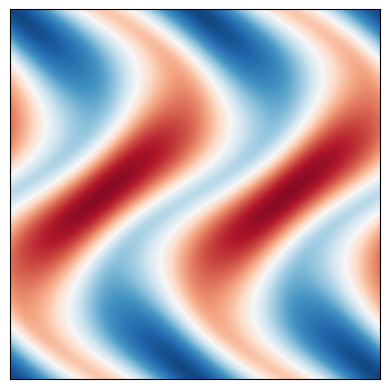

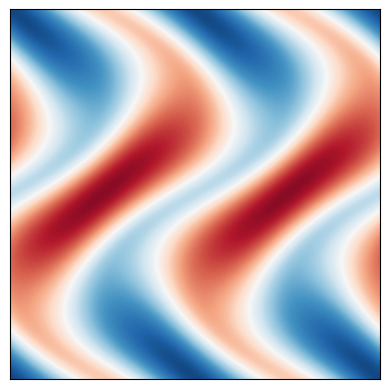

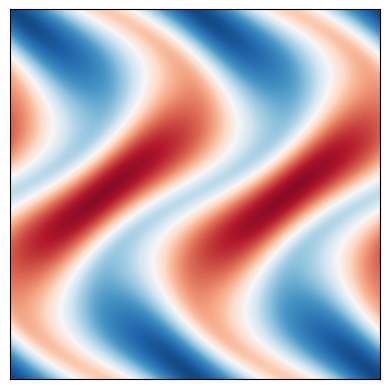

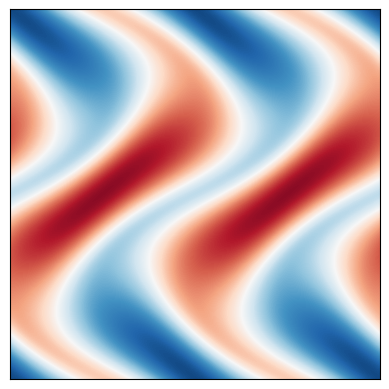

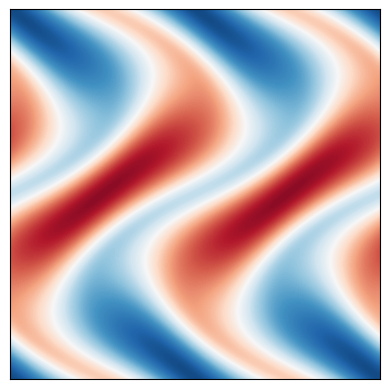

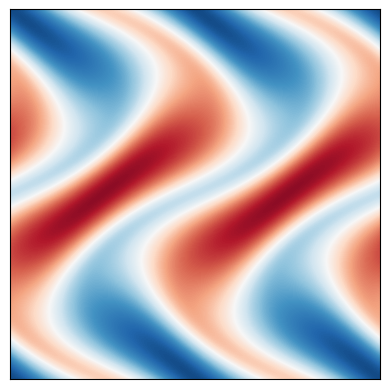

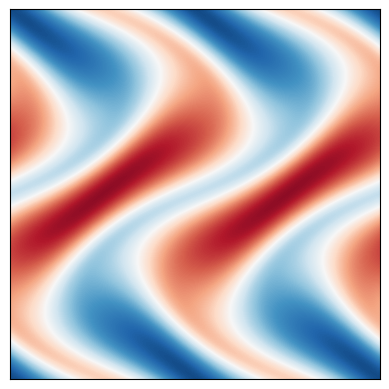

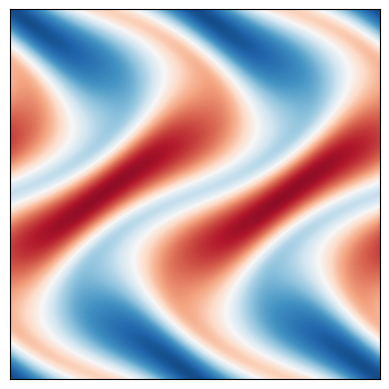

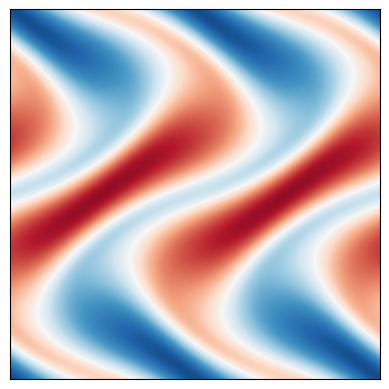

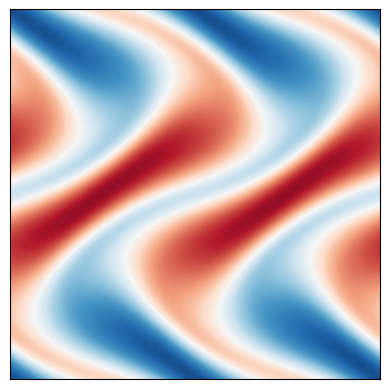

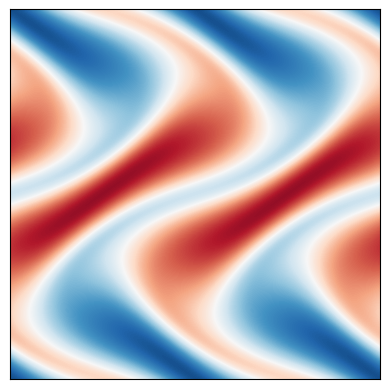

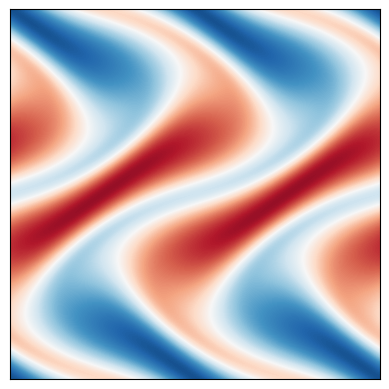

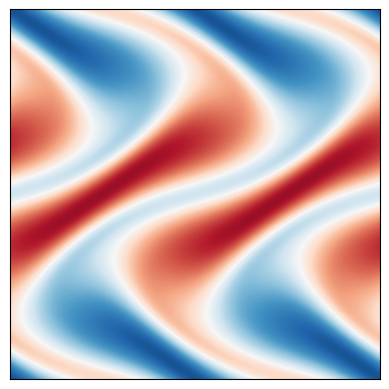

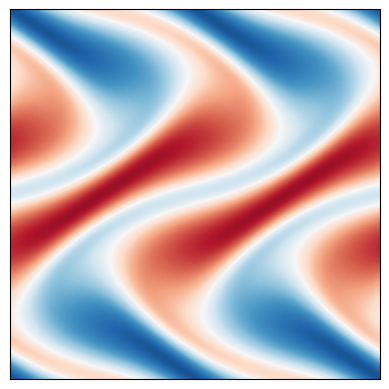

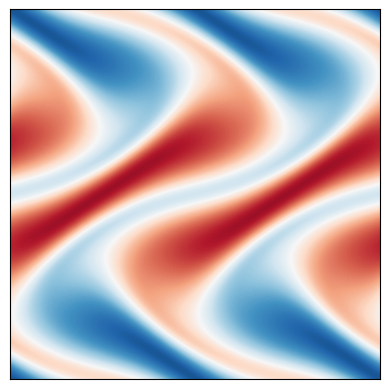

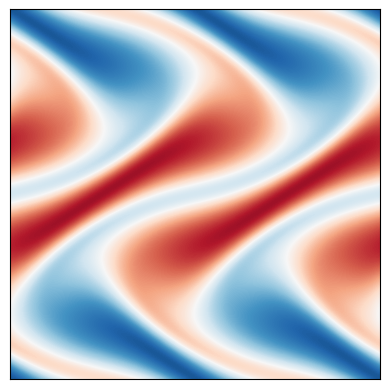

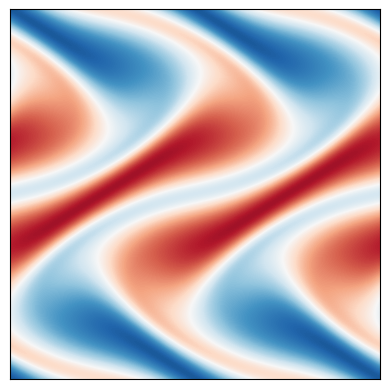

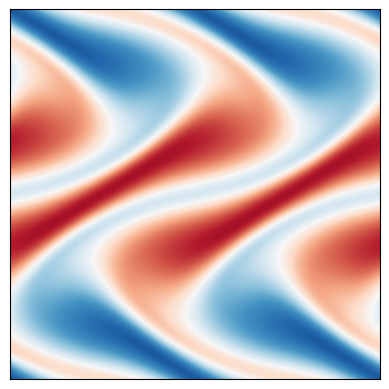

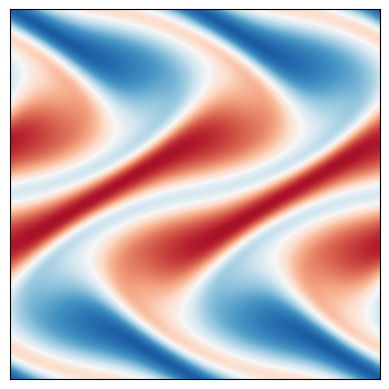

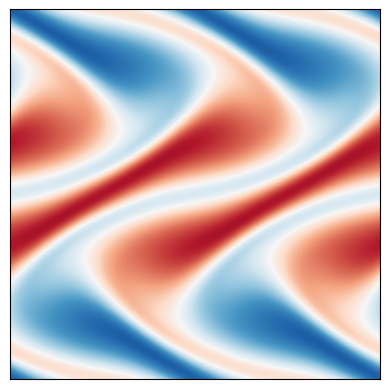

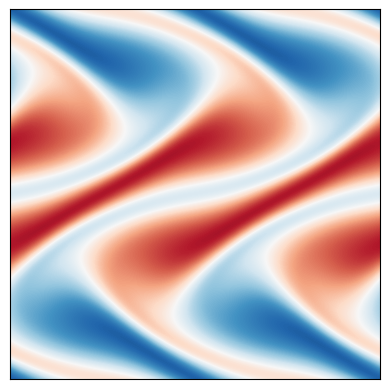

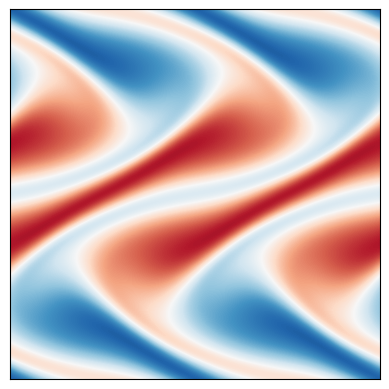

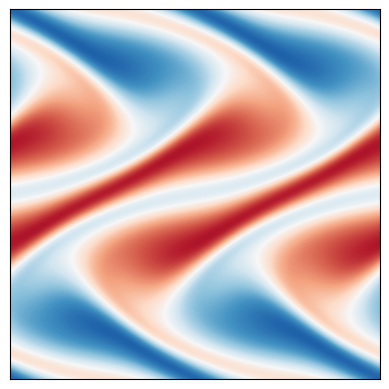

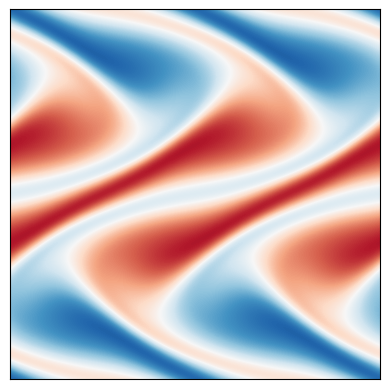

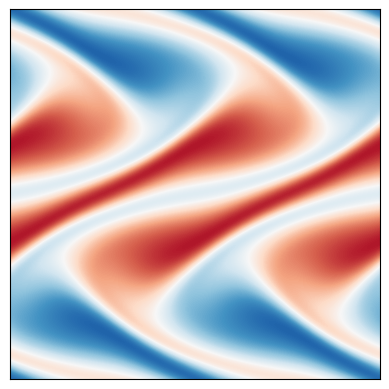

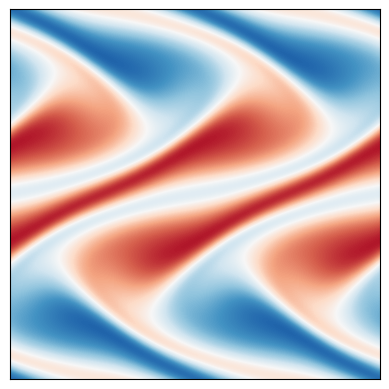

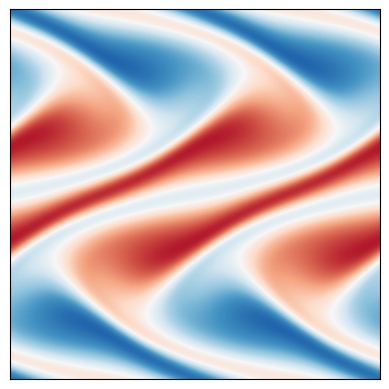

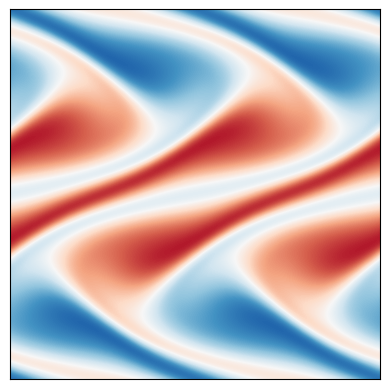

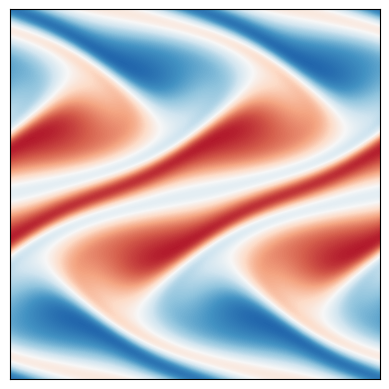

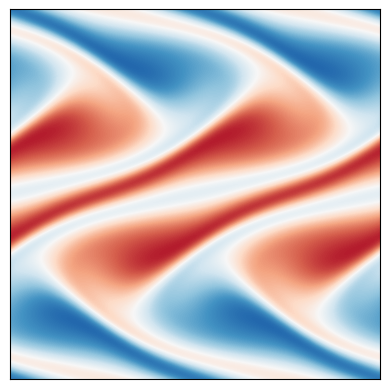

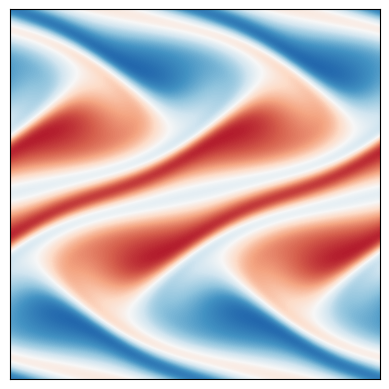

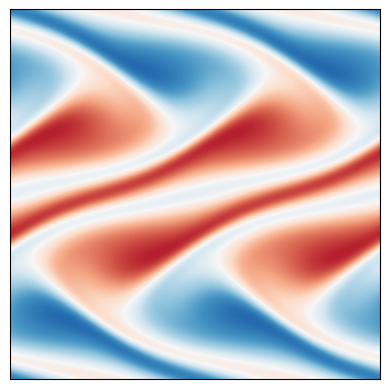

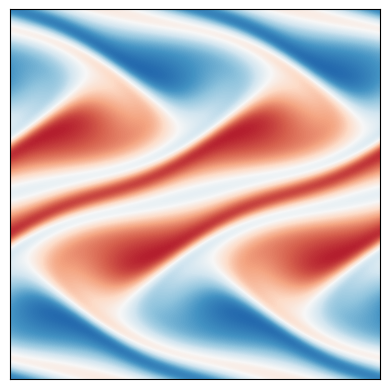

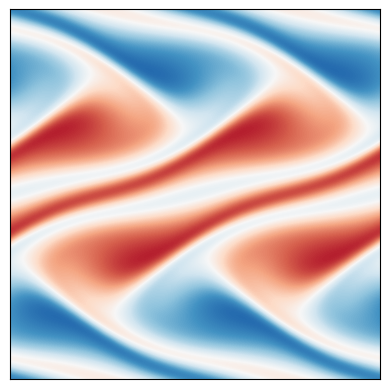

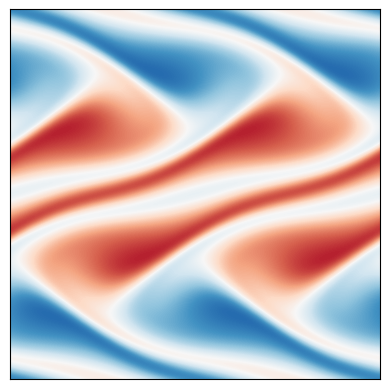

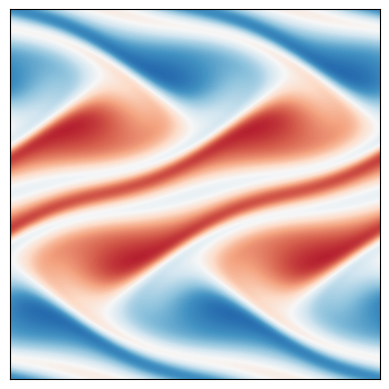

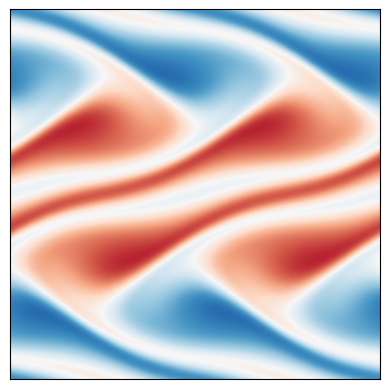

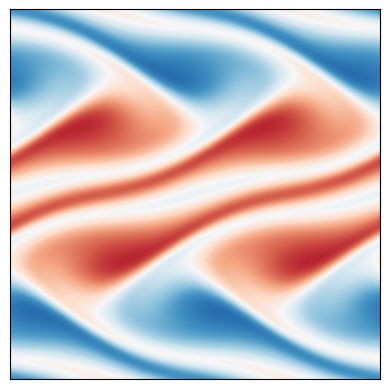

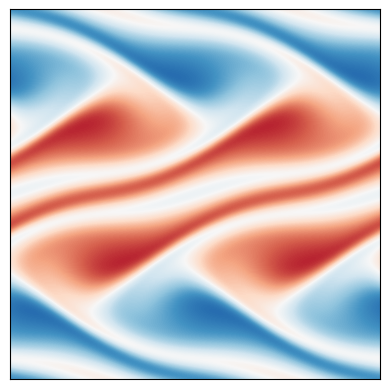

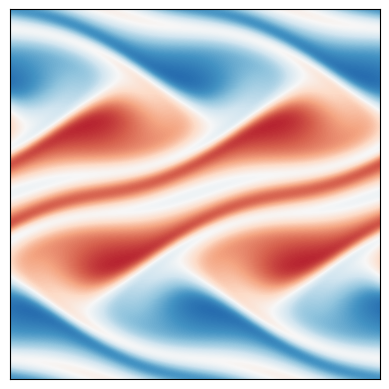

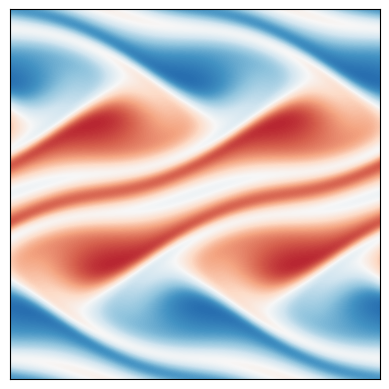

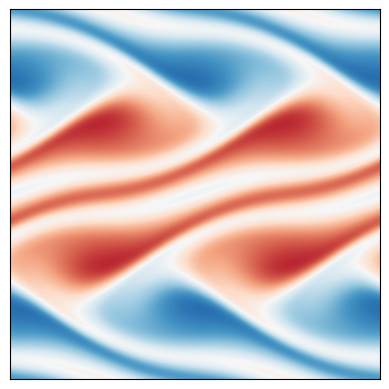

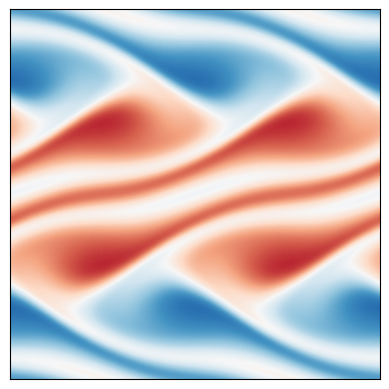

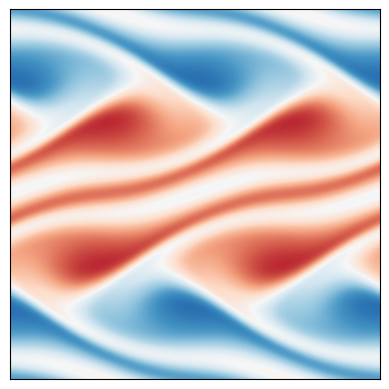

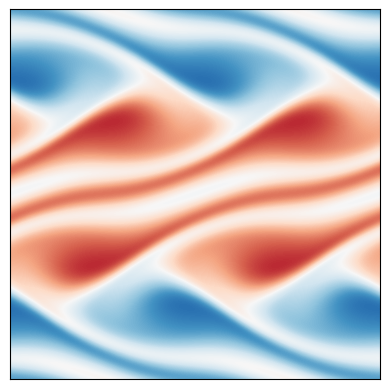

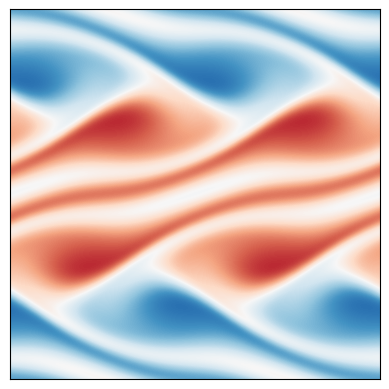

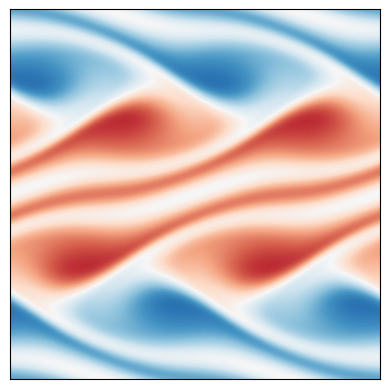

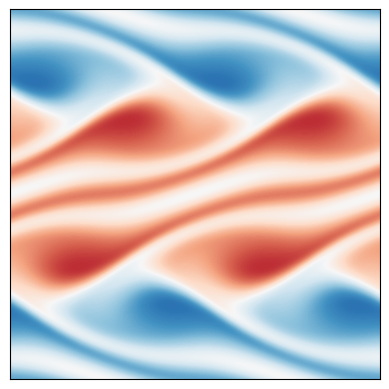

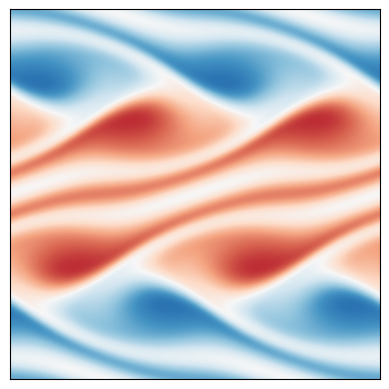

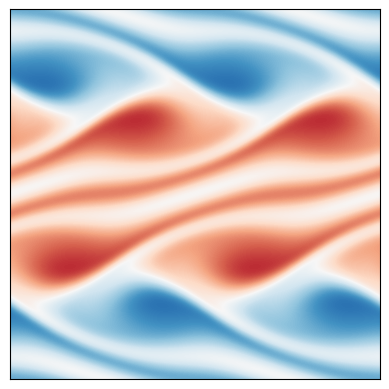

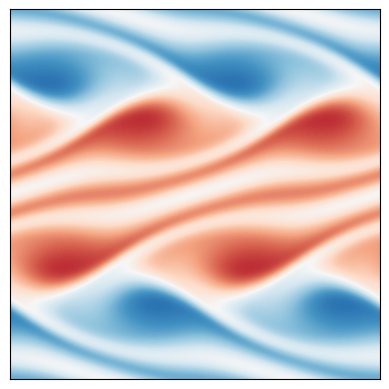

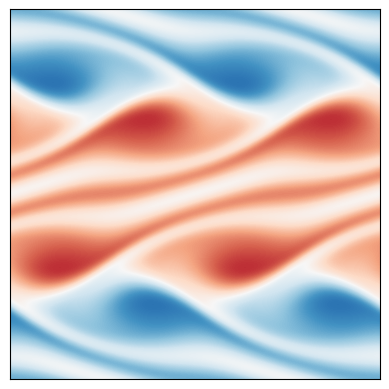

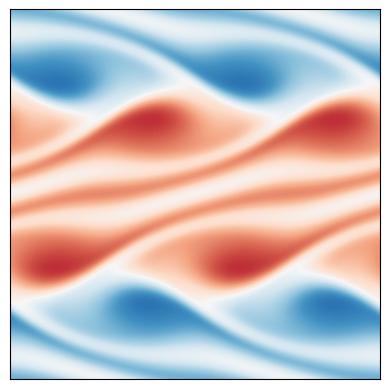

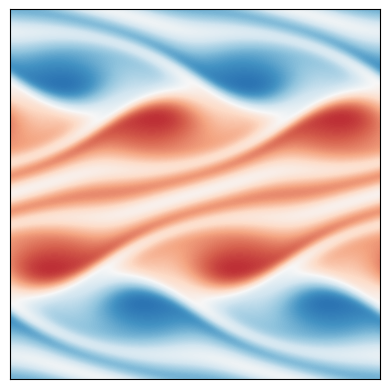

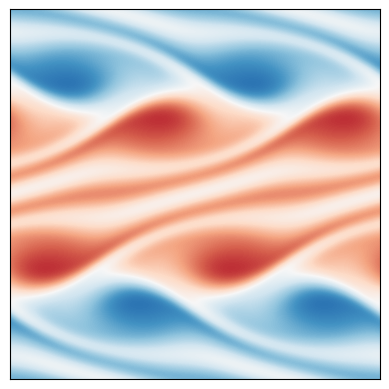

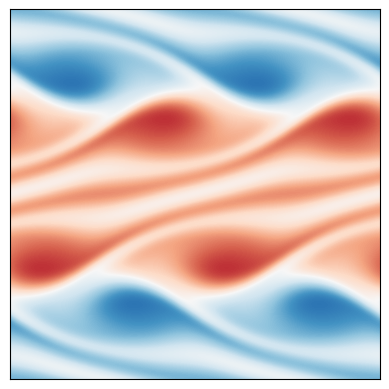

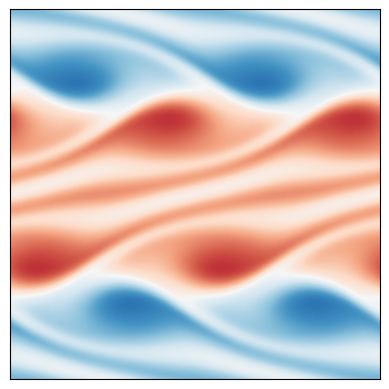

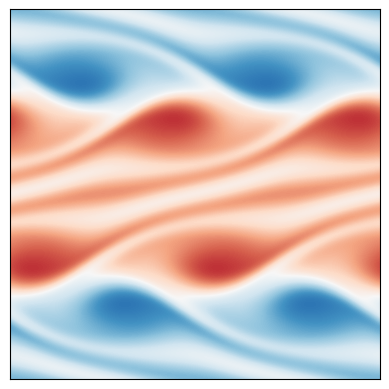

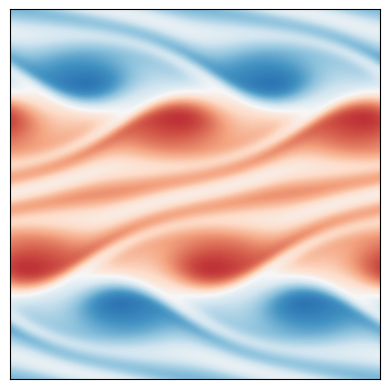

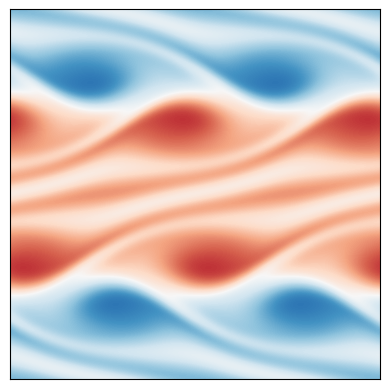

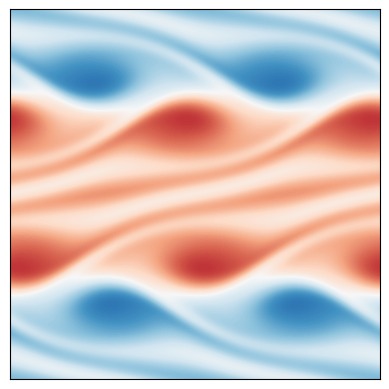

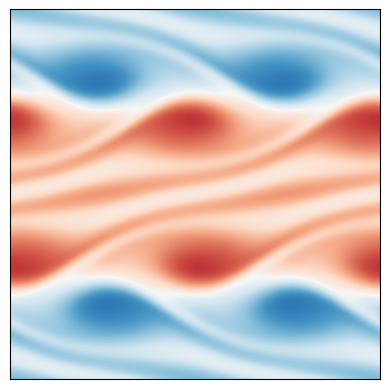

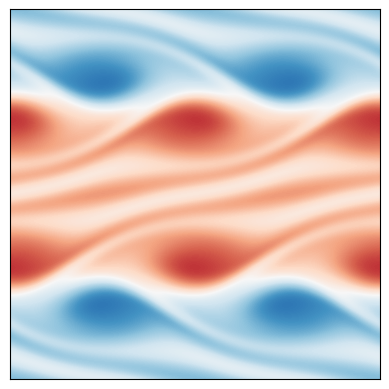

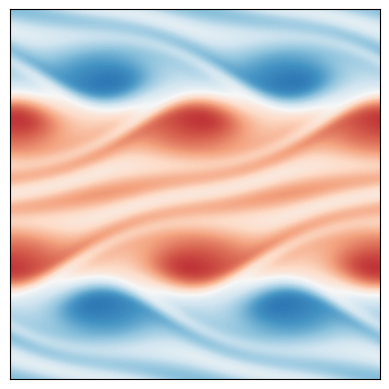

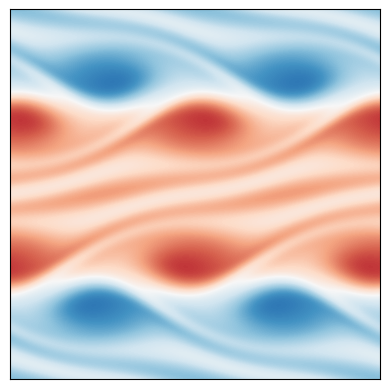

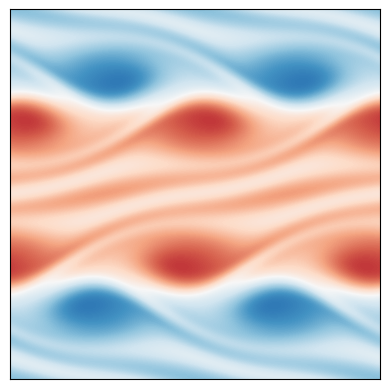

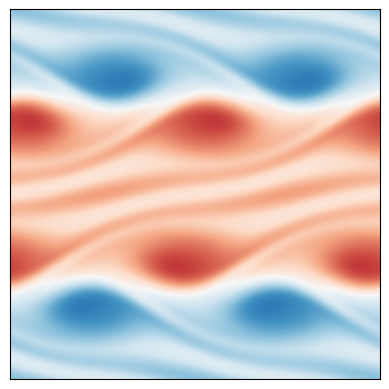

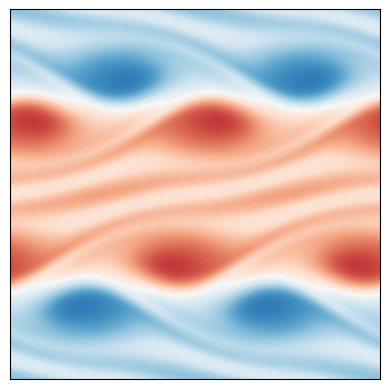

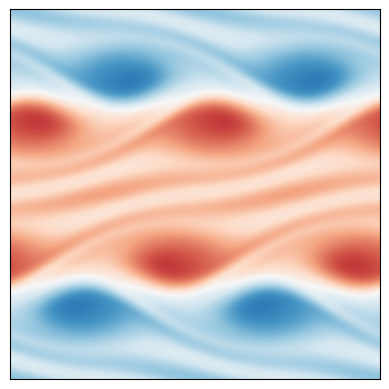

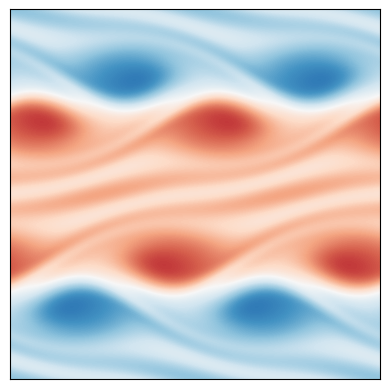

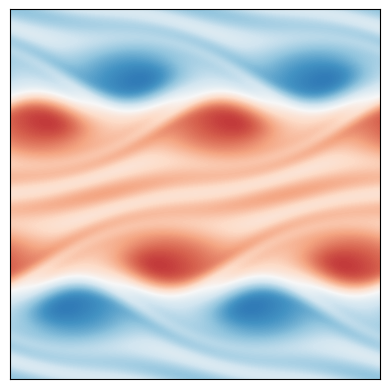

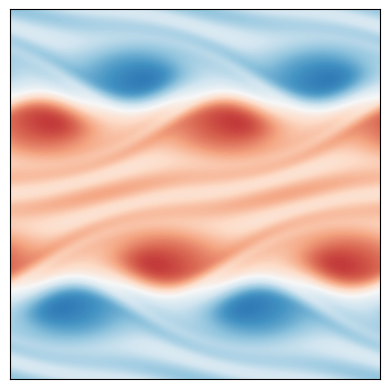

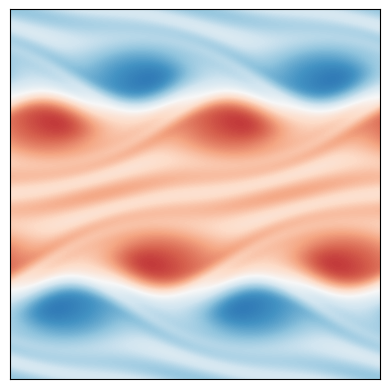

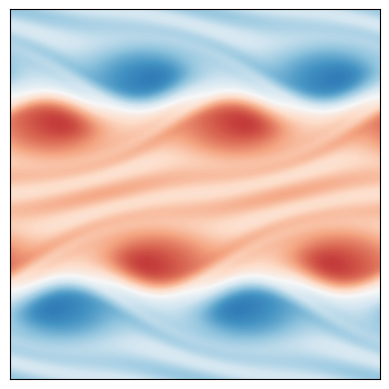

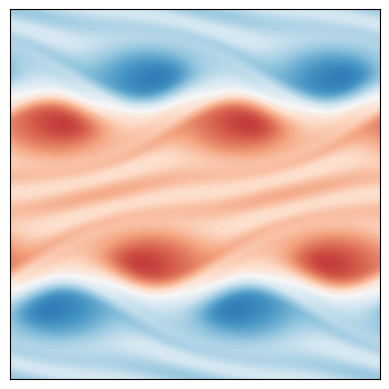

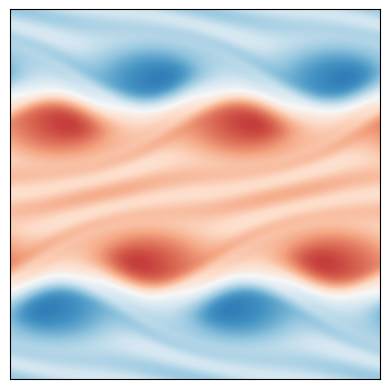

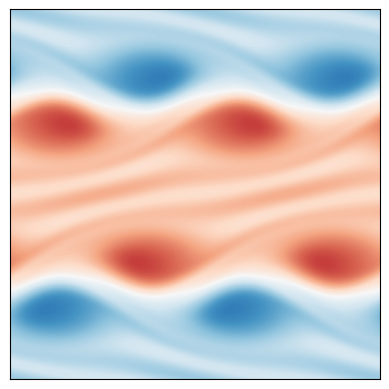

<Figure size 640x480 with 0 Axes>

In [15]:
if __name__ == '__main__':
	main()